In [1]:
from sklearn import datasets, linear_model, metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

## Część 1

In [2]:
#ustawienia
time_multiplicator = 100
seed = 244810
samples = 2410

In [3]:
XY,C  = datasets.make_classification(n_features=2,n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed,  )

In [4]:
from sklearn.model_selection import train_test_split
XY_train, XY_test, C_train, C_test = train_test_split(XY, C, test_size=0.2, random_state=0)


In [5]:
# C_train = np.where(C_train==0, -1, C_train) 
# C_test = np.where(C_test==0, -1, C_test) 

In [6]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


XY_train = norm(XY_train)
XY_test = norm(XY_test)
C_train = norm(C_train)
C_test = norm(C_test)

### sklearn

In [7]:
#sklearn
sk_time = time.time()
for i in range(time_multiplicator):
    sk_ridge_ans= linear_model.RidgeClassifier(alpha=2e-16).fit(XY_train,C_train)
sk_time = (time.time() - sk_time)/time_multiplicator 


In [8]:
sk_pred = sk_ridge_ans.predict(XY_test)

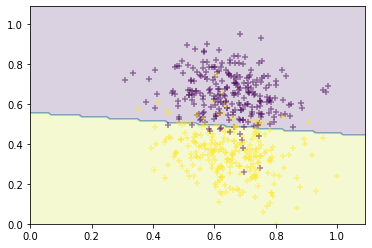

In [9]:
mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]

predict = sk_ridge_ans.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)

plt.contourf(mesh, mesh.T, predict, alpha=0.2)
#plt.scatter(XY_train[:, 0], XY_train[:, 1], c=C_train, marker="+", alpha=0.5)
plt.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

### Własna implementacja

In [10]:
#analityczna
def my_ridge(XY, C, k): 
    return np.linalg.pinv(XY.T @ XY + k * np.identity(len(XY.T))) @ XY.T @ C


In [11]:
my_time = time.time()
for i in range(time_multiplicator):
    my_ridge_ans = my_ridge(XY_train, C_train, 1e-100)
my_time = (time.time() - my_time)/time_multiplicator 


In [12]:
def my_prediction(theta, XY):
    Y_pred = XY @ theta
    mean = np.mean(Y_pred)
    
    ans = []
    
    for x in Y_pred:
        if x >= mean:
            ans.append(1.0)
        else:
            ans.append(0.0)
    
    return np.asarray(ans)

In [13]:
my_pred = my_prediction(my_ridge_ans, XY_test)

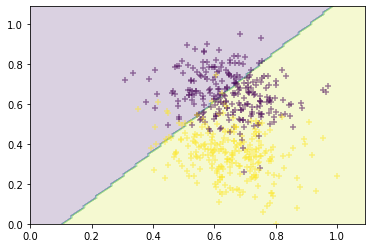

In [14]:
#magiczny kod do wyświetlania

mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]

my_pred_print = my_prediction(my_ridge_ans, np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)

plt.contourf(mesh, mesh.T, my_pred_print, alpha=0.2)

x = [0,1]
y=[0,0]
y[0] = sk_ridge_ans.coef_[0][1]*x[0] +sk_ridge_ans.coef_[0][0]
y[1] = sk_ridge_ans.coef_[0][1]*x[1] +sk_ridge_ans.coef_[0][0]

#plt.plot(x,y)
#plt.scatter(XY_train[:, 0], XY_train[:, 1], c=C_train, marker="+", alpha=0.5)
plt.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

### Porównanie

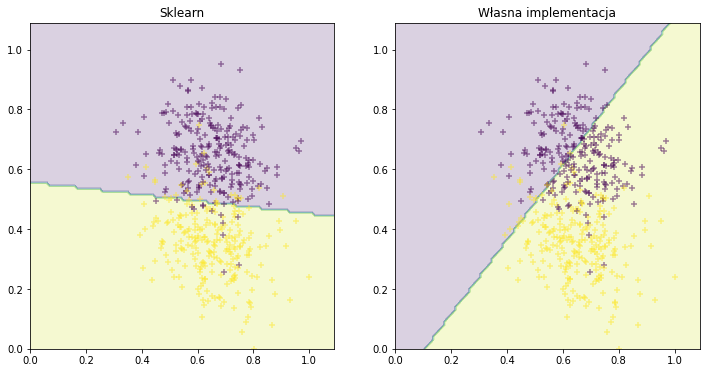

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

ax1.set_title("Sklearn")
ax1.contourf(mesh, mesh.T, predict, alpha=0.2)
ax1.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

ax2.set_title("Własna implementacja")
ax2.contourf(mesh, mesh.T, my_pred_print, alpha=0.2)
ax2.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

In [16]:
print("Sklearn czas: {:f}".format(my_time))
print("Wlasny  czas: {:f}".format(sk_time))

Sklearn czas: 0.000070
Wlasny  czas: 0.001140


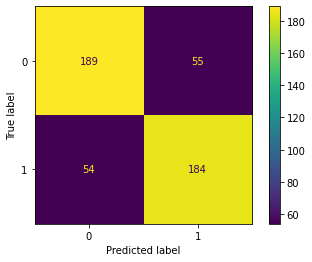

In [17]:
my_cm = metrics.confusion_matrix(C_test, my_pred)
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot()

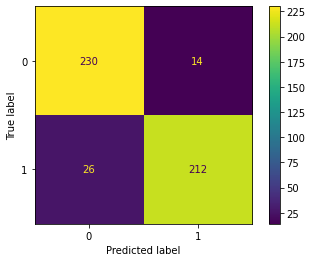

In [18]:
sk_cm = metrics.confusion_matrix(C_test, sk_pred)
sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
sk_disp.plot()

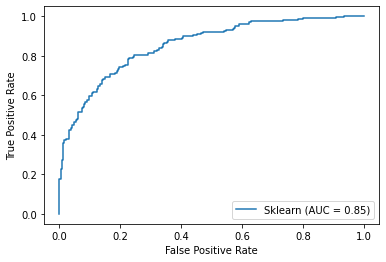

In [19]:

fpr, tpr, thresholds = metrics.roc_curve(C_test, XY_test @ my_ridge_ans)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
display.plot()

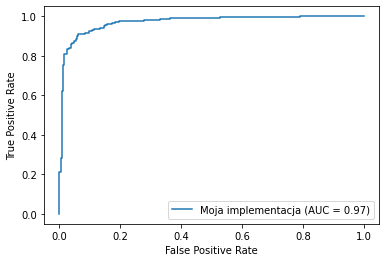

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(C_test, sk_ridge_ans.decision_function(XY_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Moja implementacja')
display.plot()

In [21]:
print("Sklearn czułość: ",sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]))
print("Wlasny  czułość: ",my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))
print()
print("Sklearn specyficzność: ",sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]))
print("Wlasny  specyficzność: ",my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]))
print()
print("Sklearn skuteczność: ",metrics.accuracy_score(sk_pred, C_test))
print("Wlasny  skuteczność: ",metrics.accuracy_score(my_pred, C_test))

Sklearn czułość:  0.8984375
Wlasny  czułość:  0.7777777777777778

Sklearn specyficzność:  0.4796380090497738
Wlasny  specyficzność:  0.4932975871313673

Sklearn skuteczność:  0.91701244813278
Wlasny  skuteczność:  0.7738589211618258


## Część 2

In [39]:
import pandas as pd 
cleveland = pd.read_csv('processed.cleveland.data', header=None, names=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"])
cleveland = cleveland.apply(pd.to_numeric, errors='coerce')
cleveland - cleveland.dropna()
cleveland

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0    0  
1      2.0  3.0   3.0    2  
2      2.0  2.0   7.0    1  
3      3.0  0.0   3.0    0  
4      1.0  0.0   3.0    0  
..     ...  ...   ...  ...  
298    2.0  0.0   7.0    1  
299    2.0  2.0   7.0    2  
300    2.0  1.0   7.0    3  
301    2.0  1.0   3.0    1  
302    1.0  NaN   3.0    0  

[303 rows x 14 columns]

In [40]:
#zmienna przewidywana jako wartości binarne
cleveland.loc[cleveland['num'] > 0,'num'] = 1
cleveland.loc[cleveland['num'] == 0, 'num'] = -1

In [41]:
cleveland

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0   -1  
1      2.0  3.0   3.0    1  
2      2.0  2.0   7.0    1  
3      3.0  0.0   3.0   -1  
4      1.0  0.0   3.0   -1  
..     ...  ...   ...  ...  
298    2.0  0.0   7.0    1  
299    2.0  2.0   7.0    1  
300    2.0  1.0   7.0    1  
301    2.0  1.0   3.0    1  
302    1.0  NaN   3.0   -1  

[303 rows x 14 columns]